In [1]:
import os

# Define base directory
data_dir = '/kaggle/input/ivision-mrssd/iVision-MRSSD/iVision-MRSSD/images'

# List subdirectories
for root, dirs, files in os.walk(data_dir):
    print(f'In {root}, found {len(files)} files and {len(dirs)} folders.')

In /kaggle/input/ivision-mrssd/iVision-MRSSD/iVision-MRSSD/images, found 0 files and 3 folders.
In /kaggle/input/ivision-mrssd/iVision-MRSSD/iVision-MRSSD/images/val, found 2318 files and 0 folders.
In /kaggle/input/ivision-mrssd/iVision-MRSSD/iVision-MRSSD/images/test, found 1160 files and 0 folders.
In /kaggle/input/ivision-mrssd/iVision-MRSSD/iVision-MRSSD/images/train, found 8112 files and 0 folders.


In [13]:
import os
import random
from collections import defaultdict
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array

In [15]:
# Set base path
base_path = "/kaggle/input/ivision-mrssd/iVision-MRSSD/iVision-MRSSD/images"
splits = ['train', 'val', 'test']

# Set 7:2:1 ratio (Total 2100 images)
max_train = 1470
max_val = 420
max_test = 210

# Satellite name mapping from filename prefixes
satellite_prefixes = {
    "Alo": "ALOS-PALSAR (L-band, Japan)",
    "Cap": "Capella (X-band, USA)",
    "Ice": "ICEYE (X-band, Finland)",
    "Ter": "TerraSAR-X (X-band, Germany)",
    "Paz": "Paz (X-band, Spain)",
    "Sen": "Sentinel-1 (C-band, ESA/Italy)"
}

In [17]:
# Initialize data holders
satellite_images = defaultdict(list)
image_counts = {"train": 0, "val": 0, "test": 0}
resolutions = set()

# Create a dictionary to hold image data and corresponding labels
train_images = []
val_images = []
test_images = []

# Process each split
for split in splits:
    split_path = os.path.join(base_path, split)
    image_list = glob(f"{split_path}/*.jpg")
    random.seed(42)  # For reproducibility
    random.shuffle(image_list)

    if split == "train":
        image_list = image_list[:max_train]
    elif split == "val":
        image_list = image_list[:max_val]
    elif split == "test":
        image_list = image_list[:max_test]

    image_counts[split] = len(image_list)

    for img_path in image_list:
        filename = os.path.basename(img_path)

        # Match satellite name by prefix
        sat_name = "Unknown"
        for prefix, full_name in satellite_prefixes.items():
            if filename.startswith(prefix):
                sat_name = full_name
                break

        satellite_images[sat_name].append(img_path)

        try:
            with Image.open(img_path) as img:
                resolutions.add(img.size)
        except:
            pass

        # Load image data (convert to numpy array) and corresponding label
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        image = img_to_array(image)  # Convert to numpy array
        label = image  # For reconstruction, the label is the same as the input image
        
        # Split data according to the split
        if split == 'train':
            train_images.append(image)
        elif split == 'val':
            val_images.append(image)
        elif split == 'test':
            test_images.append(image)

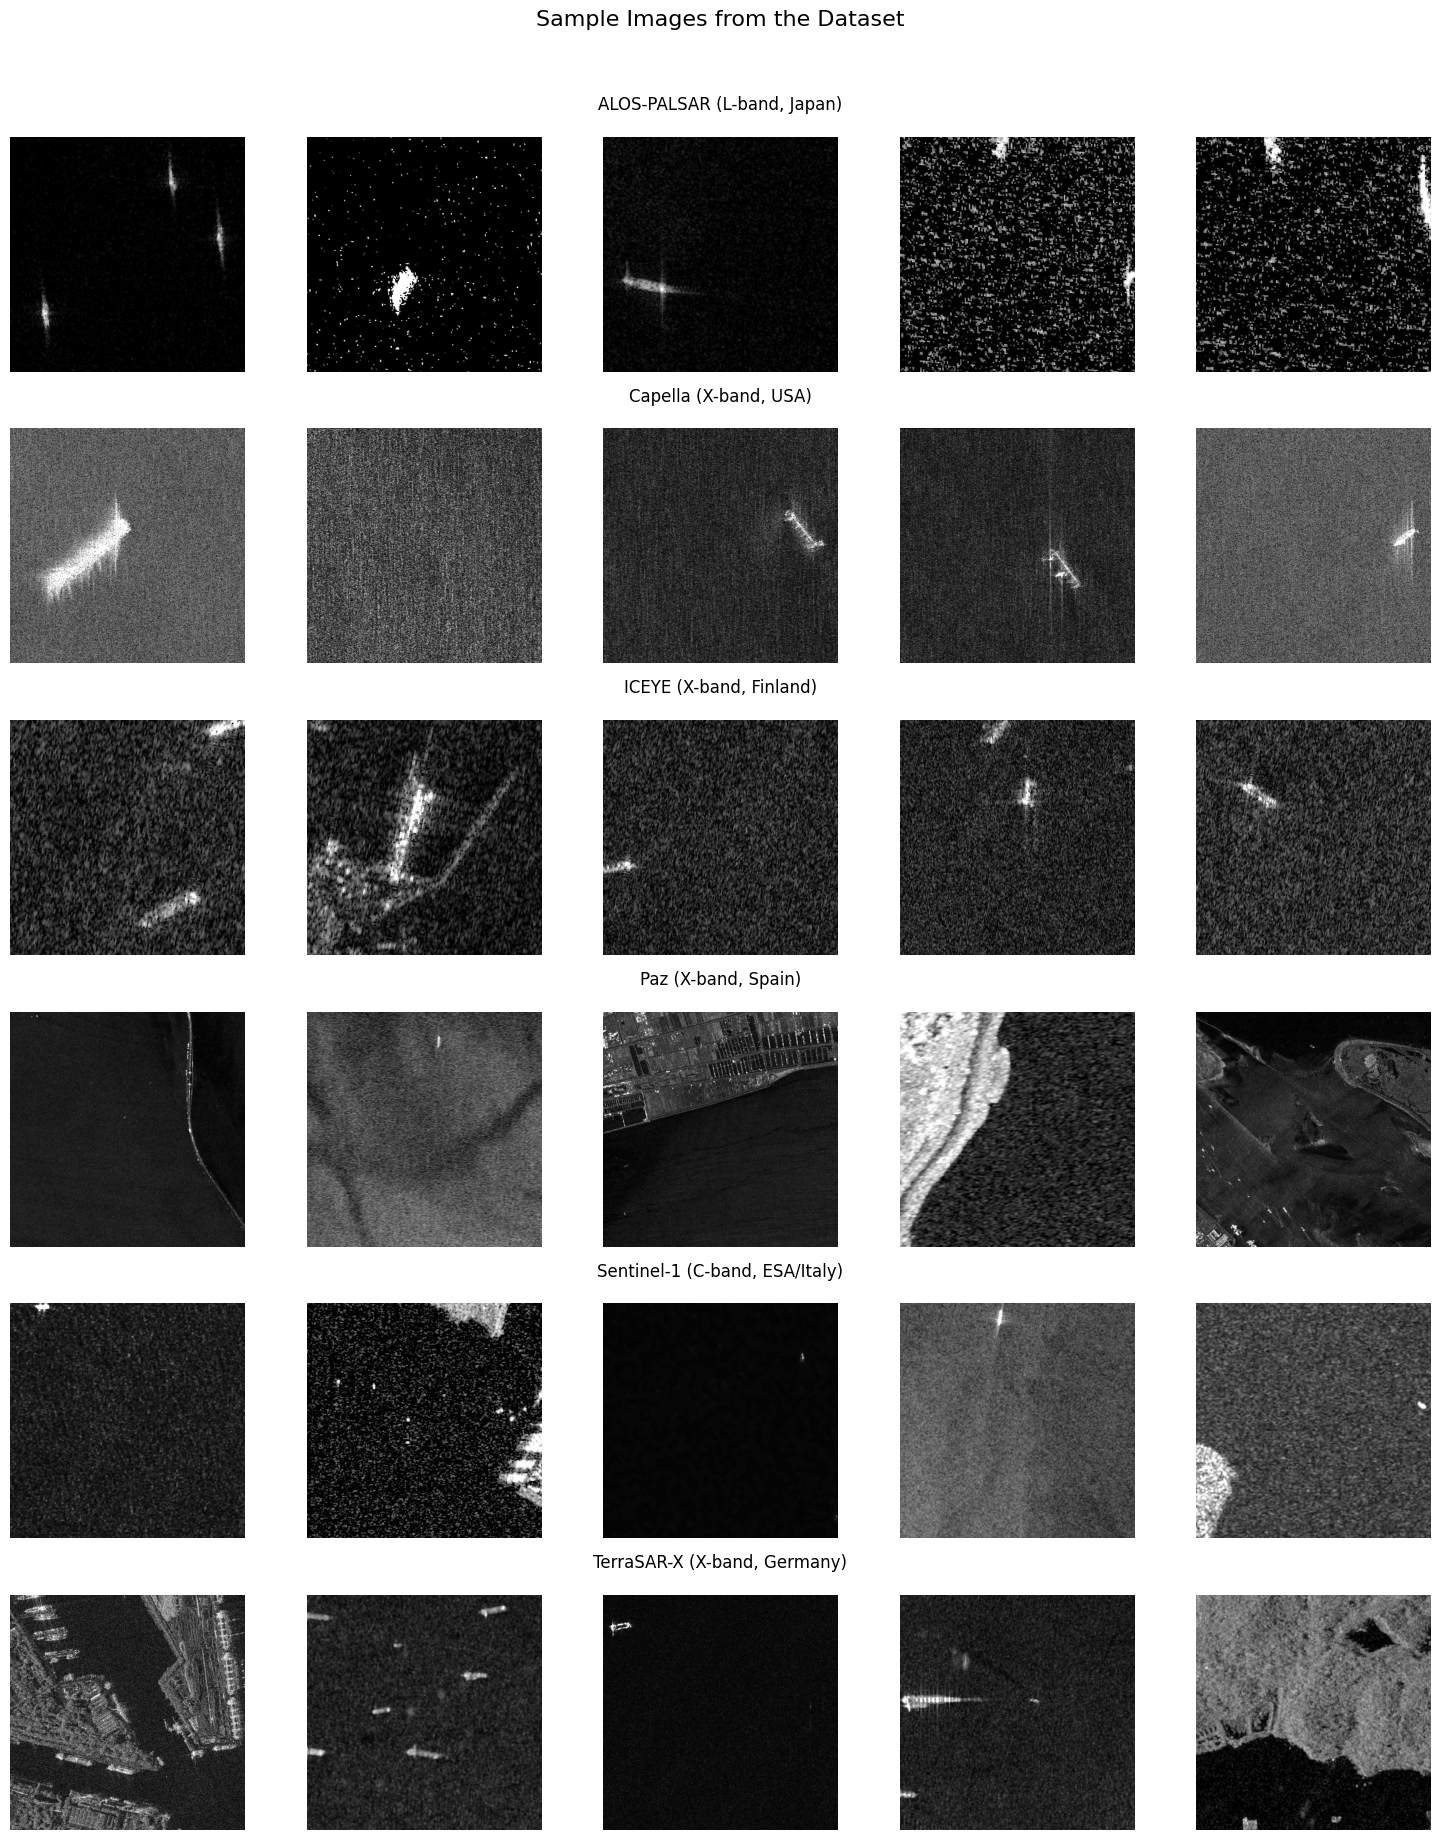

In [30]:
import matplotlib.pyplot as plt
from PIL import Image
import random

# Config
rows = len(satellite_images)
cols = 5
figsize = (cols * 3, rows * 3)

# Create figure
fig, axs = plt.subplots(rows, cols, figsize=figsize)

# Ensure axs is 2D even for single row
if rows == 1:
    axs = [axs]

# Sort for consistent layout
sorted_satellite_images = dict(sorted(satellite_images.items()))

# Plot
for row_idx, (sat_name, paths) in enumerate(sorted_satellite_images.items()):
    sample_paths = random.sample(paths, min(cols, len(paths)))
    
    for col_idx in range(cols):
        ax = axs[row_idx][col_idx]
        ax.axis('off')
        
        if col_idx < len(sample_paths):
            img = Image.open(sample_paths[col_idx]).convert("L")
            ax.imshow(img, cmap='gray')

    # Add title above the middle image in the row
    axs[row_idx][cols // 2].set_title(sat_name, fontsize=12, pad=20)

# Add overall figure title
plt.suptitle("Sample Images from the Dataset", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf

def build_sr_cnn(input_shape=(512, 512, 1), scale_factor=2):
    input_img = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    residual = x

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.Add()([x, residual])

    x = tf.keras.layers.UpSampling2D(size=(scale_factor, scale_factor), interpolation='bilinear')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    output_img = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    return tf.keras.models.Model(inputs=input_img, outputs=output_img)

model = build_sr_cnn(input_shape=(512, 512, 1), scale_factor=1)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


I0000 00:00:1744880410.795338     242 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744880410.799231     242 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 512, 512, 64)   │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 512, 512, 64)   │              0 │ add[0][0]              │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 512, 512, 1)    │            577 │ conv2d_5[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 185,857 (726.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm

def load_images_from_folder(folder, max_images=None):
    images = []
    filenames = sorted(os.listdir(folder))
    for idx, filename in enumerate(tqdm(filenames)):
        if filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = img.astype(np.float32) / 255.0
                img = cv2.resize(img, (512, 512))
                images.append(img)
            if max_images and len(images) >= max_images:
                break
    images = np.expand_dims(np.array(images), axis=-1)  # Add channel dim
    return images

# Convert list of images to NumPy arrays and normalize
train_hr = np.expand_dims(np.array(train_images, dtype=np.float32) / 255.0, axis=-1)
val_hr = np.expand_dims(np.array(val_images, dtype=np.float32) / 255.0, axis=-1)
test_hr = np.expand_dims(np.array(test_images, dtype=np.float32) / 255.0, axis=-1)


# Create corresponding LR images
def create_lr_images(images, factor=2):
    lr_images = tf.image.resize(images, [images.shape[1] // factor, images.shape[2] // factor], method='area')
    lr_images = tf.image.resize(lr_images, [images.shape[1], images.shape[2]], method='bilinear')
    return lr_images.numpy()

train_lr = create_lr_images(train_hr)
val_lr = create_lr_images(val_hr)
test_lr = create_lr_images(test_hr)

In [ ]:
history = model.fit(
    train_lr, train_hr,
    validation_data=(val_lr, val_hr),
    epochs=20,
    batch_size=8
)

In [ ]:
import matplotlib.pyplot as plt

# Assume history is the returned object from model.fit
history = sr_cnn_model.history

# Plotting training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

# Evaluate the model on the test set
test_loss = sr_cnn_model.evaluate(test_images, test_images)  # Reconstruction is same as input
print(f"Test Loss: {test_loss}")

# Calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    return psnr

# Calculate PSNR for a batch of images
psnr_values = [calculate_psnr(test_images[i], sr_cnn_model.predict(np.expand_dims(test_images[i], axis=0))[0]) 
               for i in range(10)]  # Evaluate on first 10 images

print(f"PSNR for first 10 images: {psnr_values}")


In [ ]:
import random

# Display some random test images and their reconstructions
for i in range(5):  # Show 5 random test images
    idx = random.randint(0, len(test_images) - 1)
    original = test_images[idx]
    reconstructed = sr_cnn_model.predict(np.expand_dims(original, axis=0))[0]

    # Plotting the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.show()

In [ ]:
import os
import cv2

# Create directory to store reconstructed images if it doesn't exist
output_dir = './reconstructed_images'
os.makedirs(output_dir, exist_ok=True)

# Save reconstructed images
for i in range(10):  # Save first 10 images
    original = test_images[i]
    reconstructed = sr_cnn_model.predict(np.expand_dims(original, axis=0))[0]
    
    # Save the reconstructed image
    reconstructed_image = (reconstructed * 255).astype(np.uint8)  # Convert back to [0, 255] range
    output_path = os.path.join(output_dir, f"reconstructed_{i}.png")
    cv2.imwrite(output_path, reconstructed_image)

print(f"Reconstructed images saved to {output_dir}")
